<a href="https://colab.research.google.com/github/juno-yuu/MFE-DAML/blob/main/Problem_Set_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Set 6

Team members: Junnuo Yu, Xinyan Zhang, Dennis Deng, Ziqi Ren, Qinhao Liu

### Creating a sentiment index from text data
#### 1. Run the codes from the lecture to preprocess the data and create the text files corresponding to each date in the news headline data. That is, remove numbers, make all lower case, remove stopwords, stemming, etc. Use PlaintextCorpusReader to load the corpus. Now, each document corresponds to a different date in the dataset.

In [ ]:
get_ipython().magic('reset -sf') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#!pip install pysentiment2
!pip install scikit-plot
!pip install pysentiment2

In [ ]:
import os
import nltk
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import sklearn.metrics   as metrics
import pysentiment2      as ps
import scikitplot        as skplt

from collections      import Counter
from nltk.stem        import WordNetLemmatizer
from nltk             import ngrams
from wordcloud        import WordCloud
from nltk.tokenize    import word_tokenize #sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus      import stopwords, PlaintextCorpusReader
from sklearn.linear_model     import LogisticRegressionCV,LogisticRegression
#from statsmodels.discrete.discrete_model import Logit
from sklearn import preprocessing
from IPython import get_ipython
from PIL import Image
from wordcloud import ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
business = pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /business_insider_text_data2.csv")
vix = pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /vix_data.csv")

In [ ]:
# merger rows with same date
business_edited = business.groupby('Date').Headline.apply(lambda x : x.tolist()).to_frame()['Headline'].apply(pd.Series).add_prefix('Top_').fillna(' ')
# use Date as index
vix_ind = vix.set_index('Date')
data = pd.merge(vix_ind,business_edited,on='Date',how='left')
data = data.dropna(axis=0) #meger two df
data.reset_index(inplace=True)
data = data.rename(columns = {'index':'Date','label':'Label'})
data #convert to a in-class kind data

In [ ]:
def create_df(dataset):
    stop_words = set(stopwords.words('english'))
    lm         = ps.LM()
    dataset    = dataset.drop(columns=['Date', 'Label'])
    dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

    for col in dataset.columns:
        dataset[col] = dataset[col].str.lower()
        dataset[col] = dataset[col].str.replace('b ','')
    headlines  = []
    head_clean = []
    sentscore  = []
    porter = PorterStemmer()

    for row in range(len(dataset.index)):
        document = ' '.join(str(x) for x in dataset.iloc[row, 0:25])
        headlines.append(document)
        tokens  =  word_tokenize(document)
        stemmed = [porter.stem(word) for word in tokens]
        words   = [w for w in stemmed if not w in stop_words]
        head_clean.append(' '.join(word for word in words))
        tokens  = lm.tokenize(' '.join(word for word in words))
        sentscore.append(lm.get_score(tokens)['Polarity'])
    df              = pd.DataFrame(headlines, columns=['All'])
    df['processed'] = head_clean
    df['score']     = sentscore
    # data is the dataset after filling NaNs defined out of the function scope
    df['label'] = data.Label 
    df['date']  = data.Date
    
    entire_processed_text = ' '.join(doc for doc in head_clean)
    return df[['date','label','All','processed','score']], entire_processed_text



In [ ]:
df_full, entire_text = create_df(data)

In [ ]:
os.chdir('/content/drive/MyDrive/MFE 431 DAML /Corpus')
for ind in range(len(df_full)):
    file_id = df_full.date[ind]
    with open('file_'+file_id+'.txt','w') as fout:
        fout.write(df_full.processed[ind])
        fout.close()

In [ ]:
# here, set the directory you defined for the Corpus in the initialization script
corpus_root = '/content/drive/MyDrive/MFE 431 DAML /Corpus'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')
#newcorpus = PlaintextCorpusReader('/content/drive/MyDrive/MFE 431 DAML /Corpus', '.*')

In [ ]:
def dtm_from_corpus(xCorpus):
    '''
    Create a dtm from a corpus. 
    '''
    s = 0
    # this code works on my laptop, but if you have an apple these usually put
    # in a .DS_Store file. Uncommenting the below might work in that case
    # probably... make sure there are no hidden files in your Corpus folder!
    # if so, these need to not be included in the dtm obviously. I feel like
    # there should be a better way to do this, but this is it for now.

    if '.DS_Store' in newcorpus.fileids(): s=1

    fd_list = []
    for x in range(s, len(xCorpus.fileids())):
        fd_list.append(nltk.FreqDist(xCorpus.words(xCorpus.fileids()[x])))
    dtm = pd.DataFrame(fd_list, index = xCorpus.fileids()[s:])
    dtm.fillna(0,inplace = True)
    return dtm

#### 2. As in the lecture note, create a DocumentTermMatrix, call it dtm. Run the line “dtm.iloc[5:10,201:210].” Notice that the matrix is quite sparse (a lot of zeros).

In [ ]:
dtm = dtm_from_corpus(newcorpus)
dtm.iloc[5:10,201:210]

,report,valeant,appoint,provok,peril,administr,send,messag,competit
file_2016-01-11.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
file_2016-01-12.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
file_2016-01-13.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
file_2016-01-14.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
file_2016-01-15.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. As in the lecture note, create a frequency matrix as the column sums of the DTM. Show in a bar plot the frequency of words that occur more than 25 times.

In [ ]:
def word_frequency(sentence,stopwords):
    '''
    joins all the sentence, creates tokens, creates lower class, removes
    numbers and lemmatizes the words
    '''
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in s_words]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the words, pairs and trigrams
    counted   = Counter(new_tokens)
    counted_2 = Counter(ngrams(new_tokens,2))
    counted_3 = Counter(ngrams(new_tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

In [ ]:
freq = pd.DataFrame(dtm.sum())
freq.columns = {'Frequency'}
freq_filtered = freq.query('Frequency >25').sort_values(by=['Frequency'],ascending=False)
freq_filtered.reset_index(inplace=True)
freq_filtered = freq_filtered.rename(columns = {'index':'Word'})

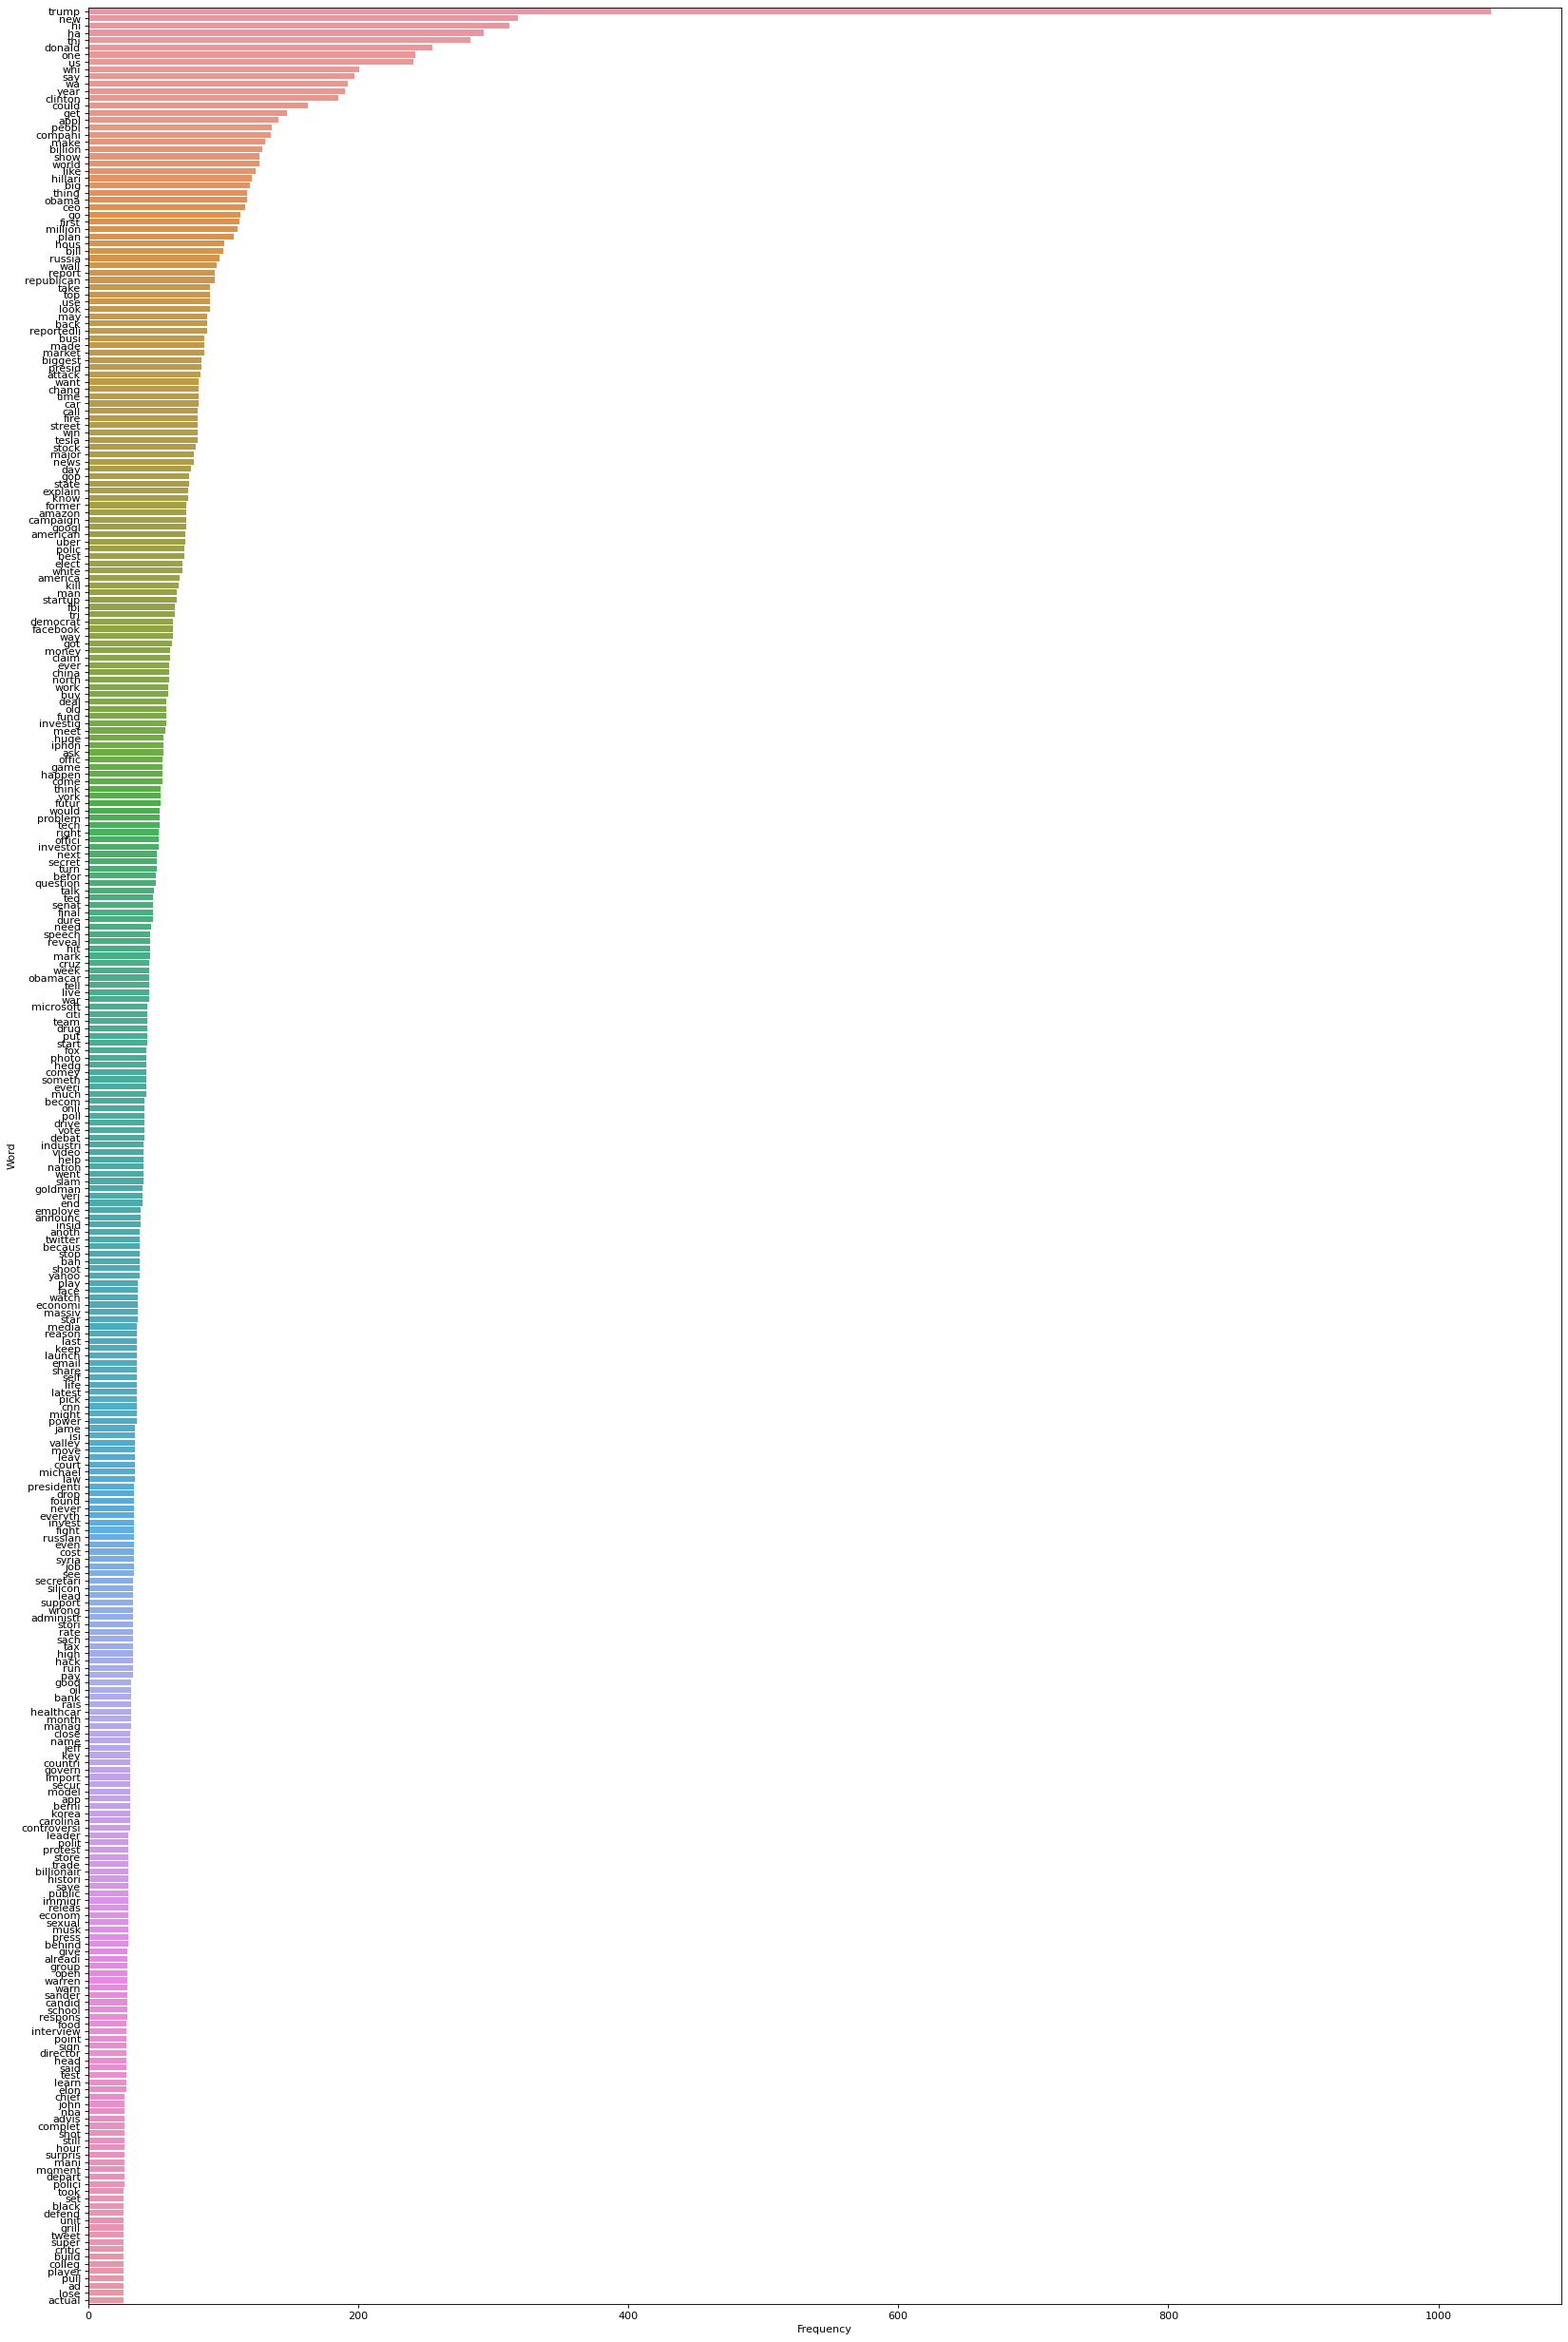

In [ ]:
ax = plt.figure(figsize=(25,40),dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x='Frequency',y='Word',data=freq_filtered)

#### 4. Create a wordcloud of the 20 most frequent words. Based on this (and 3.), how would you characterize the typical headline in terms of the news subject? Are there words that, intuitively, can matter for the stock market returns that day?

In [ ]:
s_words = stopwords.words('english')
data2, data3, data4 = word_frequency(entire_text,s_words)

4. Create a wordcloud of the 20 most frequent words. Based on this (and 3.), how would you
characterize the typical headline in terms of the news subject? Are there words that, intuitively,
can matter for the stock market returns that day?

The 20 most frequent wordcloud is below:

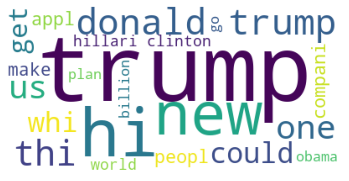

In [ ]:
# Plot 20 most frequent words
wc = WordCloud(max_words=20,stopwords={'say','ha','wa','u'},background_color="white").generate_from_text(entire_text)
plt.figure()
plt.imshow(wc)
plt.axis('off')
plt.show()

Below is just for fun

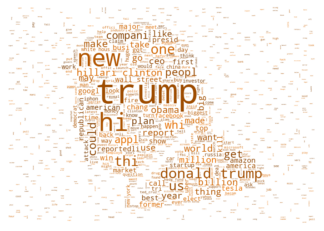

In [ ]:

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
mask = np.array(Image.open('/content/drive/MyDrive/MFE 431 DAML /trump.png'))
mask_colors = ImageColorGenerator(mask)
wc = WordCloud(max_words=1000,stopwords={'say','ha','wa','u'},background_color="white",mask=mask,color_func=random_color_func).generate_from_text(entire_text)
plt.figure()
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

**Comment:** Based on the world cloud, the typical headline is about politics as we oberserved many politicians' names. Similarily, we can see that from Question 3 that 'trump' was mentioned far more frequently than other words.
That would possibly affect the stock market as political actions like regulation adn laws may have an impact on companies on their fundamental performance. There are many topics about president candidates. Since presidents appoint economic advisors adn fill positions such as the chair of the Federal Reserve and economic policies and the direction of the interest rate, which is set by the Federal Reserve, all above acations have an impact on the stock market.

#### 5. Create the endogenous variable “y_data = df_full['label']” and the exogenous matrix “x_data = dtm.” You will try to construct an index based on the words in dtm that predicts the direction of stock returns.

In [ ]:
y_data = df_full['label']
x_data = dtm
x_data.index = y_data.index

#### 6. Split the data into a training dataset, based on data up to and including 2016-12-31. The remaining data should be used for actual out-of-sample testing.

In [ ]:
sample_n = 238
#df_full=df_full.set_index('date')
df_full.reset_index()
train_X,test_X = x_data [:sample_n],x_data[sample_n:]
train_y,test_y = y_data [:sample_n],y_data[sample_n:]

#### 7. We will first let the logistic regression create the word-based index. That is, try to fit a regular logistic regression using y_data and x_data and the training dataset. Explain why this doesn’t work


In [ ]:
logit_data = sm.GLM(y_data,sm.add_constant(x_data),family=sm.families.Binomial()).fit()
logit_data.summary()

PerfectSeparationError: ignored

In [ ]:
logit_train = sm.GLM(train_y,sm.add_constant(train_X),family=sm.families.Binomial()).fit()
logit_train.summary()

PerfectSeparationError: ignored

**Comment:** Separation detected:

Perfect Separation detected means that there are too many covariates in the regression. This happens when all or nearly all of the values in one of the predictor categories (or a combination of predictors) are associated with only one of the binary outcome values. By looking into the actual Excel dataset,some variables are with very limited distributions across the group. 

#### 8. Next, run a logistic regression with an elastic net constraint (let l1_ratio= 0.5) using crossvalidation and the training dataset. Why does the regression routine work now (i.e., why does it give an answer (a coefficient vector; no meltdown))? Explain.

In [ ]:
# Elastic net with cross validation
mod1 = LogisticRegressionCV(penalty='elasticnet',solver = 'saga',  
            l1_ratios=[0.5], cv = 10, max_iter = 10^6,fit_intercept = False,refit=True)
mod1 = mod1.fit(train_X, train_y)

In [ ]:
ind =pd.DataFrame(np.argwhere(mod1.coef_!=0))
coef=pd.DataFrame(mod1.coef_)
coef_notzero =coef[[ind.iloc[0,1]]]
coef_notzero.rename(columns={coef_notzero.columns[0]:str(train_X.columns[142])})

,donald
0,-0.085313


#### 9. Using .C_ (the penalizing term chosen by the cross validation), what (if any) are the words chosen and their associated coefficients? Comment on your results.

In [ ]:
# Best penalizing term
best_alpha_cv = mod1.C_

# Estimate the model again using this "best" alpha
mod1wp = LogisticRegression(penalty='elasticnet',solver = 'saga', 
                          l1_ratio=0.5, max_iter = 1000,fit_intercept = True)
mod1wp.C=best_alpha_cv[0]
mod1wp.fit(train_X, train_y)
# look at estimated coefficients 
ind =pd.DataFrame(np.argwhere(mod1wp.coef_!=0))
coef=pd.DataFrame(mod1wp.coef_)
not_zero = coef[[ind.iloc[0,1]]]
not_zero.rename(columns={not_zero.columns[0]:str(train_X.columns[142])})

,donald
0,-0.075473


#### 10. Now, create instead a pre-defined sentiment word list: sent_words =["trump","invest","growth","grow","high","strong","lead","good","risk","debt","oil","loss","war","rate","hous","weak"] dtm_sentiment = dtm[sent_words] Run the elastic net with “x_data_pre=dtm_sentiment” using cross-validation and the training sample. Create a bar plot with the words on the x-axis and the coefficients on the y-axis. Comment on differences and similarities to the case in 9. Again, get the coefficients using c_.

In [ ]:
sent_words = ["trump","invest","growth","grow","high","strong","lead","good","risk","debt","oil","loss","war" ,"rate","hous","weak"]

dtm_sentiment = dtm[sent_words]
# get unigram fequency of these words
dtm_sentiment_sum = dtm_sentiment.sum()
dtm_sentiment_sum
y_data = df_full['label']
x_data_pre = dtm_sentiment
x_data_pre.index = y_data.index

In [ ]:
sample_n = 238
#df_full=df_full.set_index('date')
df_full.reset_index()
train_X_pre,test_X_pre = x_data_pre [:sample_n],x_data_pre[sample_n:]
train_y_pre,test_y_pre = y_data [:sample_n],y_data[sample_n:]

In [ ]:
# Elastic net with cross validation
mod2 = LogisticRegressionCV(penalty='elasticnet',solver = 'saga',  
            l1_ratios=[0.5], cv = 10, max_iter = 10^6,fit_intercept = False,refit=True)
mod2 = mod2.fit(train_X_pre, train_y_pre)
# Best penalizing term
best_alpha_cv = mod2.C_

# Estimate the model again using this "best" alpha
mod2 = LogisticRegression(penalty='elasticnet',solver = 'saga', 
                          l1_ratio=0.5, max_iter = 1000,fit_intercept = True)
mod2.C_=best_alpha_cv[0]
mod2.fit(train_X_pre, train_y_pre)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# look at estimated coefficients 
coef2=pd.DataFrame(mod2.coef_,columns=train_X_pre.columns)
coef2_notzero = (coef2[coef2!=0]).dropna(axis=1)
Coef2=coef2_notzero.T
Coef2.reset_index(inplace=True)
Coef2= Coef2.rename(columns = {'index':'Word',Coef2.columns[1]:'Coef'}).sort_values(by='Coef',ascending=False)
Coef2

,Word,Coef
11,weak,0.741877
1,grow,0.686268
8,war,0.637432
10,hous,0.346606
2,high,0.164855
0,trump,0.001930
6,debt,-0.122820
9,rate,-0.234571
3,strong,-0.311604
7,loss,-0.326792


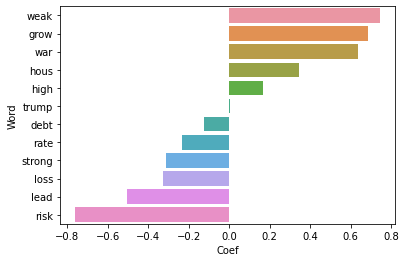

In [ ]:
ax1 = plt.figure()
sns.barplot(x='Coef',y='Word',data=Coef2)

#### 11. Create the ROC curves for the sentiment model in 10, using C_ to get coefficient vector. Is it better than random? You likely want to use the predict function to get the model predictions.


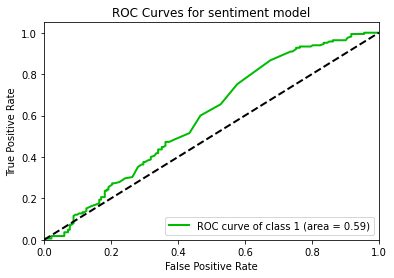

In [ ]:
ax = skplt.metrics.plot_roc(y_data,mod2.predict_proba(x_data_pre), title='ROC Curves for sentiment model',
                   plot_micro=False, plot_macro=False, classes_to_plot=1,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium")

**Comment:** Yes it's better than random as the ROC curve is $0.59$, which is greater than random $0.5$



#### 12. Now, using the test sample and the model in 10, what is the proportion of days the model would have made the right prediction in this new sample? Is it better than random (50/50)?

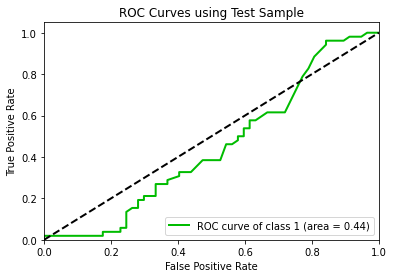

In [ ]:
ax = skplt.metrics.plot_roc(test_y_pre,mod2.predict_proba(test_X_pre), title='ROC Curves using Test Sample',
                   plot_micro=False, plot_macro=False, classes_to_plot=1,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium")

**Comment:** No it's not better than random guess, as the Area under curve is less than $0.5$.